In [ ]:
import numpy as np

np.random.seed(42)

In [1]:
from load_data import *

# 1. load and preprocess audio and label data
#X, Y_p, phoneme = load_processed_data(max_songs=5000)

# 2. get index for label data
label_to_ix = {p:i for i,p in enumerate(phoneme)}
ix_to_label = {i:p for i,p in enumerate(phoneme)}

100%|██████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19327.41it/s]


In [2]:
from torch.utils.data import Dataset
import torch

class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, label_list):
        self.mfcc_list = mfcc_list   # List of tensors (seq_len, n_mfcc)
        self.label_list = label_list # List of tensors (seq_len)

    def __len__(self):
        return len(self.mfcc_list)

    def __getitem__(self, idx):
        return self.mfcc_list[idx], self.label_list[idx]


In [3]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    mfcc_seqs, label_seqs = zip(*batch)

    mfcc_padded = pad_sequence(mfcc_seqs, batch_first=True)     # (batch_size, max_seq_len, n_mfcc)
    label_padded = pad_sequence(label_seqs, batch_first=True)   # (batch_size, max_seq_len)

    lengths = torch.tensor([seq.shape[0] for seq in mfcc_seqs]) # Original lengths

    return mfcc_padded, label_padded, lengths


In [30]:
from torch.utils.data import DataLoader
from helper_functions import *

BATCH_SIZE = 8

mfcc_list = [torch.tensor(mfcc, dtype=torch.float32) for mfcc in X]
label_list = [torch.tensor([label_to_ix[alabel[0]] for alabel in labels], dtype=torch.long) for labels in Y_p]

X_train, y_train, X_test, y_test = get_xy_split_data(mfcc_list, label_list)

train_dataset = MFCCDataset(X_train, y_train)
val_dataset = MFCCDataset(X_test[:120], y_test[:120])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [12]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.functional import log_softmax
from torch import nn

class PackedMFCCLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # Pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        
        # Unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        logits = self.fc(output)
        return torch.log_softmax(logits, dim=-1)  # shape: (batch_size, max_seq_len, num_classes)


In [25]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, n_layers=2,
                bidirectional=True, dropout=0.5):
        super().__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)

        # input size for final layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # dropout
        self.dropout = nn.Dropout(dropout)

        # final layer (fullly connected)
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x, lengths):
        # pack padded sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)

        # unpack sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        logits = self.fc(output)
        return torch.log_softmax(logits, dim=-1)

In [29]:
len(mfcc_list)

5000

In [16]:
len(label_list)

5000

In [7]:
len(train_dataset)

4000

In [8]:
len(val_dataset)

1000

In [9]:
len(train_dataloader)

500

In [10]:
len(val_dataloader)

125

In [17]:
from tqdm import tqdm  # progress bar (optional)
import torch.optim as optim
import torch.nn.functional as F

num_epochs = 10
#num_classes = model.fc.out_features  # or set manually
INPUT_DIM = 39
HIDDEN_DIM = 64
NUM_CLASSES = 41

# Define device at the top
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and send model to device
model = PackedMFCCLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
model.to(device)

# Loss function and optimizer
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0.0

    for mfcc_batch, label_batch, lengths in train_dataloader:
        # Move data to device (e.g. GPU)
        mfcc_batch = mfcc_batch.to(device)
        label_batch = label_batch.to(device)
        lengths = lengths.to(device)

        # Forward pass
        logits = model(mfcc_batch, lengths)  # shape: (batch_size, max_seq_len, num_classes)

        # Flatten predictions and labels for loss calculation
        logits_flat = logits.view(-1, NUM_CLASSES)
        labels_flat = label_batch.view(-1)

        # Loss and backprop
        loss = loss_fn(logits_flat, labels_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")


 10%|█████▋                                                   | 1/10 [05:14<47:07, 314.15s/it]

Epoch 1/10 — Loss: 2.4814


 20%|███████████▍                                             | 2/10 [10:18<41:09, 308.67s/it]

Epoch 2/10 — Loss: 1.8052


 30%|████████████████▌                                      | 3/10 [40:24<1:55:44, 992.01s/it]

Epoch 3/10 — Loss: 1.6569


 40%|██████████████████████                                 | 4/10 [45:26<1:11:57, 719.66s/it]

Epoch 4/10 — Loss: 1.5973


 50%|████████████████████████████▌                            | 5/10 [50:29<47:26, 569.32s/it]

Epoch 5/10 — Loss: 1.5443


 60%|█████████████████████████████████                      | 6/10 [1:11:03<53:01, 795.33s/it]

Epoch 6/10 — Loss: 1.5056


 70%|██████████████████████████████████████▌                | 7/10 [1:15:51<31:28, 629.67s/it]

Epoch 7/10 — Loss: 1.4791


 80%|████████████████████████████████████████████           | 8/10 [1:20:33<17:17, 518.90s/it]

Epoch 8/10 — Loss: 1.4570


 90%|█████████████████████████████████████████████████▌     | 9/10 [1:40:17<12:06, 726.87s/it]

Epoch 9/10 — Loss: 1.4338


100%|██████████████████████████████████████████████████████| 10/10 [1:44:53<00:00, 629.39s/it]

Epoch 10/10 — Loss: 1.4155


In [31]:
from sklearn.metrics import f1_score
import torch
from torch.nn.functional import log_softmax
import jiwer  # pip install jiwer if not installed

def evaluate(model, dataloader, loss_fn, device, num_classes, idx_to_token=None):
    model.eval()
    total_loss = 0.0
    per_seq_acc = []
    per_seq_f1 = []
    per_seq_wer = []
    per_seq_ids = []

    with torch.no_grad():
        for mfcc_batch, label_batch, lengths in tqdm(dataloader):
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)

            logits = model(mfcc_batch, lengths)
            loss = loss_fn(logits.view(-1, num_classes), label_batch.view(-1))
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)  # (batch_size, seq_len)

            for i in range(len(lengths)):
                pred_seq = preds[i, :lengths[i]].cpu().tolist()
                label_seq = label_batch[i, :lengths[i]].cpu().tolist()

                # Frame Accuracy for this sequence
                correct = sum(p == l for p, l in zip(pred_seq, label_seq))
                acc = correct / lengths[i].item()
                per_seq_acc.append(acc)

                # F1 Score for this sequence
                try:
                    f1 = f1_score(label_seq, pred_seq, average="macro", zero_division=0)
                except ValueError:
                    f1 = 0.0  # In case of missing classes
                per_seq_f1.append(f1)

                # WER for this sequence (requires idx_to_token)
                if idx_to_token:
                    pred_str = flat_n_get_string([idx_to_token[p] for p in pred_seq])
                    label_str = flat_n_get_string([idx_to_token[l] for l in label_seq])
                    #pred_str = " ".join([idx_to_token[p] for p in pred_seq])
                    #label_str = " ".join([idx_to_token[l] for l in label_seq])
                    wer = jiwer.wer(label_str, pred_str)
                    per_seq_wer.append(wer)
                    # find Insertions, Deletions, Substitutions
                    editops = decode_levenshtein(pred_str, label_str)
                    per_seq_ids.append(editops)

    avg_loss = total_loss / len(dataloader)
    avg_frame_acc = sum(per_seq_acc) / len(per_seq_acc)
    avg_f1 = sum(per_seq_f1) / len(per_seq_f1)
    avg_wer = sum(per_seq_wer) / len(per_seq_wer) if per_seq_wer else None

    print(f"\n🔍 Evaluation Summary")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Average Frame Accuracy: {avg_frame_acc:.4f}")
    print(f"Average F1 Score (Macro): {avg_f1:.4f}")
    if avg_wer is not None:
        print(f"Average WER: {avg_wer:.4f}")
    else:
        print("WER skipped — provide idx_to_token to enable WER computation.")

    return {
        "loss": avg_loss,
        "frame_accuracy": avg_frame_acc,
        "f1_score": avg_f1,
        "wer": avg_wer,
        "frame_scores": per_seq_acc,
        "f1_scores": per_seq_f1,
        "wer_scores": per_seq_wer,
        "IDS": per_seq_ids
    }

metrics = evaluate(
    model, val_dataloader, loss_fn, device,
    num_classes=NUM_CLASSES,  # number of output classes
    idx_to_token=ix_to_label  # optional for WER
)


100%|█████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.92it/s]


🔍 Evaluation Summary
Loss: 1.3293
Average Frame Accuracy: 0.4769
Average F1 Score (Macro): 0.2926
Average WER: 0.2928


In [72]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

def get_freqd_ids(results):
    insertions = []
    deletions = []
    substitutes = []
    equals = []
    for sequence in results:
        for entry in sequence:
            op = entry[0]; pred_ph = entry[1]; targ_ph = entry[2];
            if op == "insert":
                insertions.append(pred_ph)
            elif op == "delete":
                deletions.append(targ_ph)
            elif op == "substitute":
                substitutes.append((pred_ph, targ_ph))
            else:
                equals.append(pred_ph)
        
    return {"Insertions":FreqDist(insertions), 
            "Deletions":FreqDist(deletions), 
            "Substitutions":FreqDist(substitutes), 
            "Equals":FreqDist(equals)}

def visualise_IDE(ids_metrics, model_name="LSTM-16"):
    plt.figure(figsize=(40,10))
    
    plt.subplot(1,3,1)
    plt.bar(ids_metrics["Insertions"].keys(), ids_metrics["Insertions"].values())
    plt.title(f'{model_name} Insertions (Model adds extra labels)')
    plt.grid()
    
    plt.subplot(1,3,2)
    plt.bar(ids_metrics["Deletions"].keys(), ids_metrics["Deletions"].values())
    plt.title(f'{model_name} Deletions (Model is missing labels)')
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.bar(ids_metrics["Equals"].keys(), ids_metrics["Equals"].values())
    plt.title(f'{model_name} Correct Predictions (Model is correct)')

    plt.grid()
    plt.show()

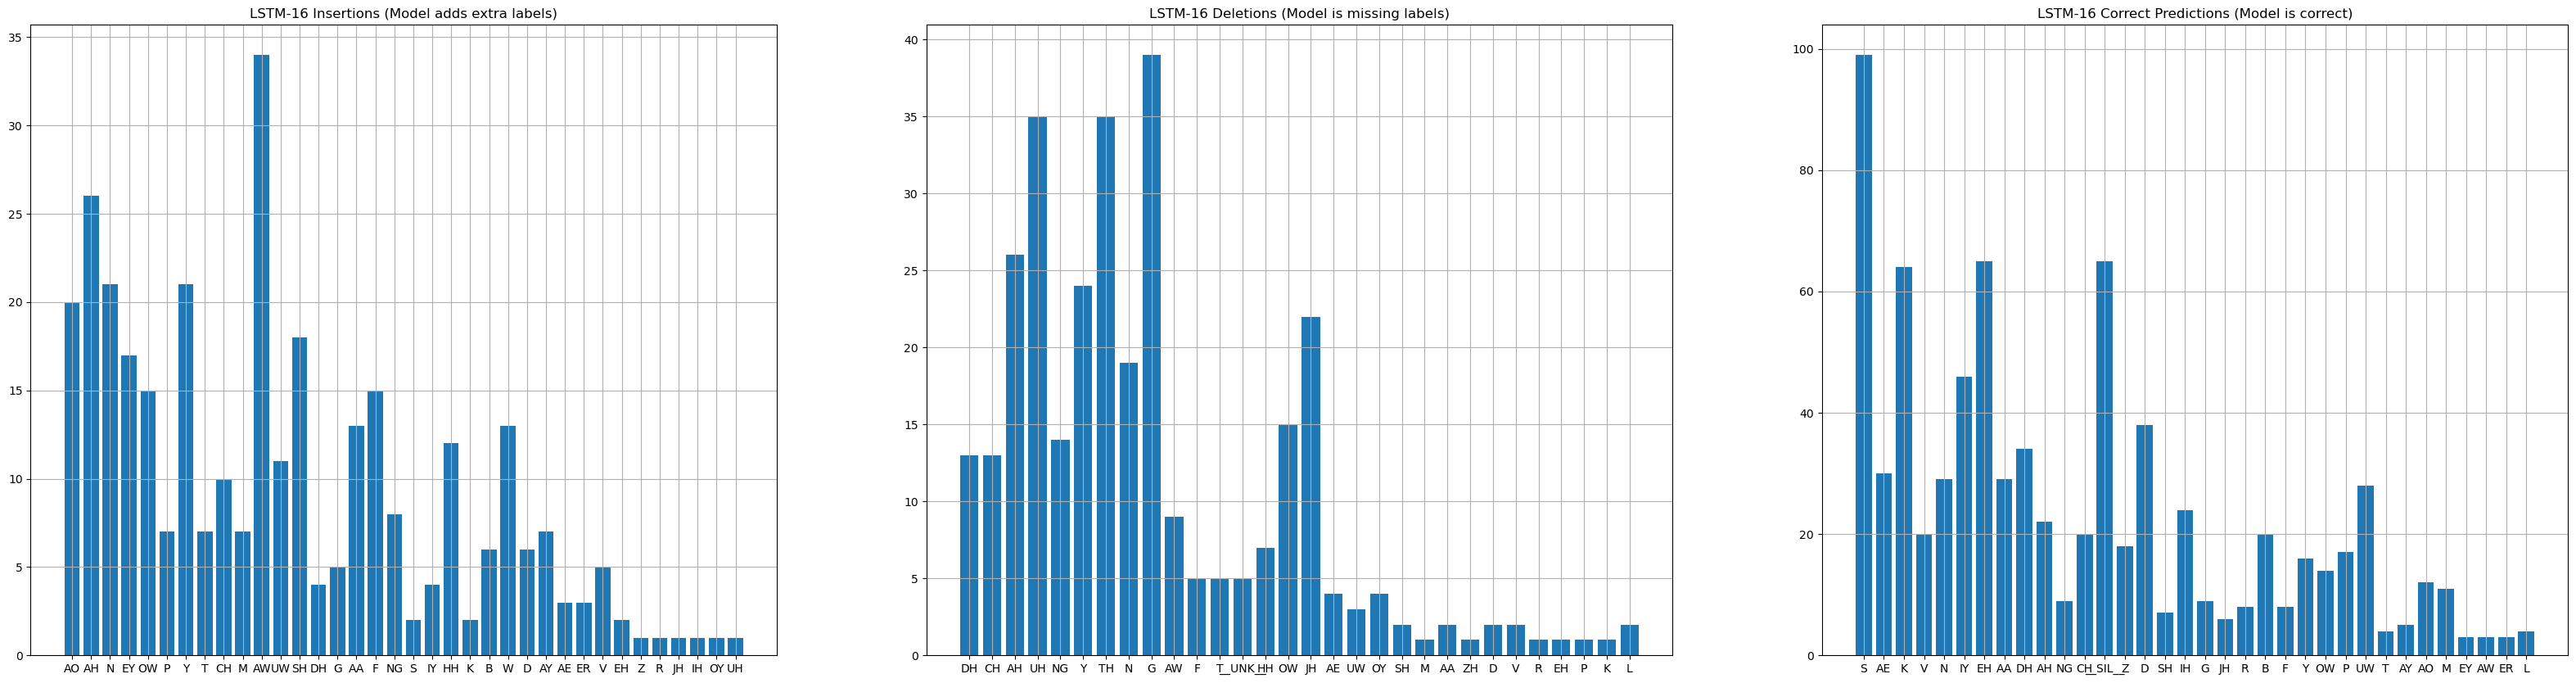

In [73]:
ids_freqd_metrics = get_freqd_ids(metrics["IDS"])
visualise_IDE(ids_freqd_metrics)

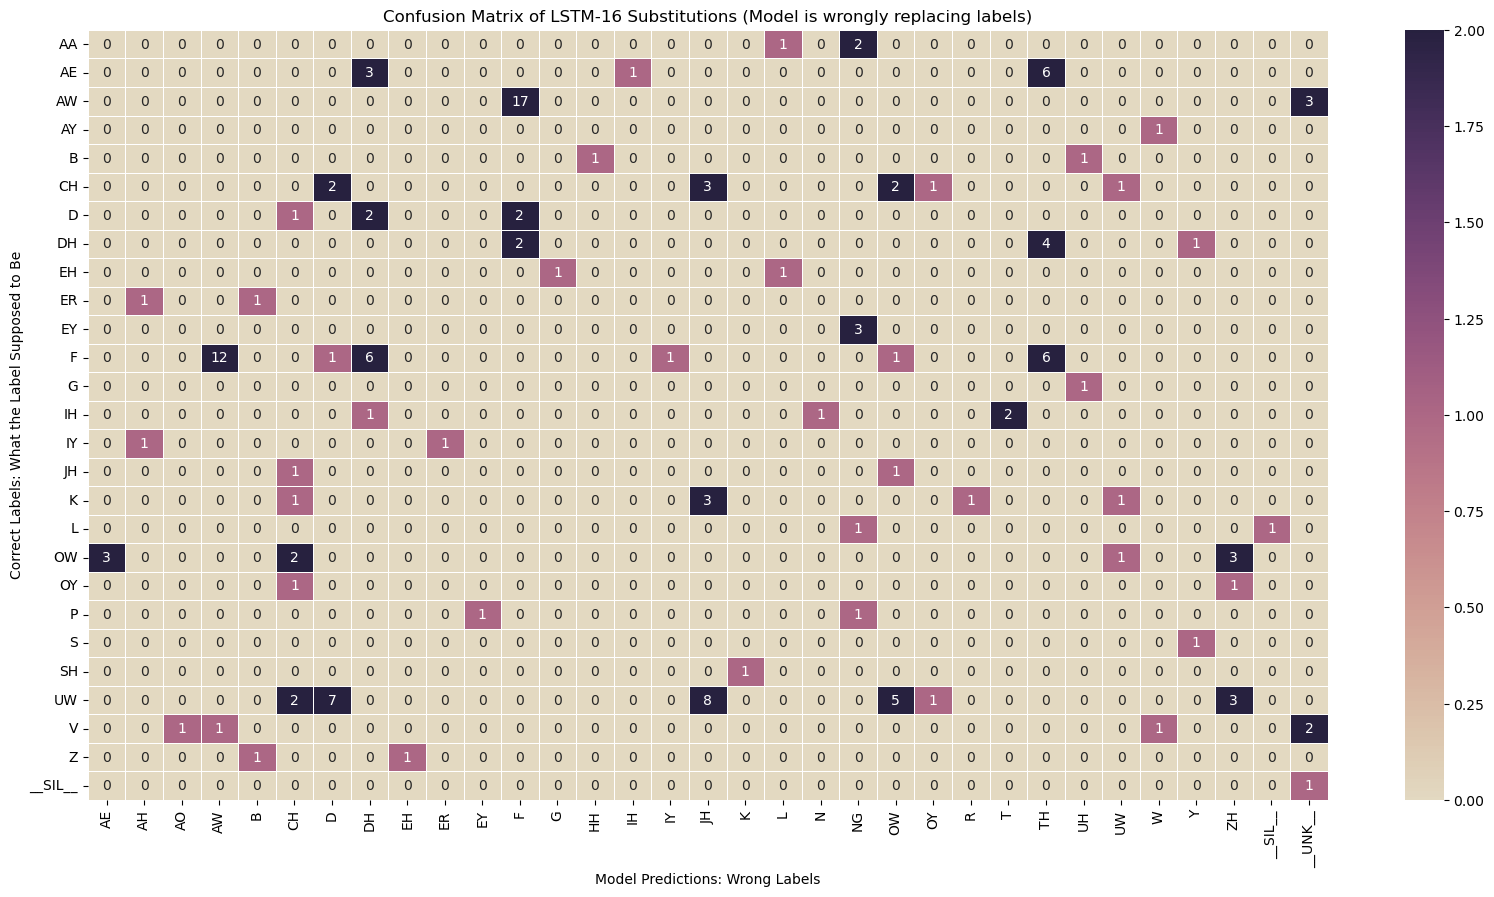

In [74]:
import seaborn as sns

def visualise_S(top_replace_freqs, model_name="LSTM-16"):
    src = set([src_token for (src_token, dst_token), freq in top_replace_freqs.items()])
    dst = set([dst_token for (src_token, dst_token), freq in top_replace_freqs.items()])
    
    src_indices = {x: i for i, x in enumerate(sorted(src))}
    dst_indices = {x: i for i, x in enumerate(sorted(dst))}

    matrix = [[0]*len(dst_indices) for _ in range(len(src_indices))]
    
    for (src_token, dst_token), freq in top_replace_freqs.items():
        src_idx = src_indices[src_token]
        dst_idx = dst_indices[dst_token]
        matrix[src_idx][dst_idx] = freq

    plt.figure(figsize=(20,10))
    ax = sns.heatmap(matrix, linewidth=0.5, xticklabels=sorted(dst), yticklabels=sorted(src), cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), annot=True, robust=True)
    plt.title(f"Confusion Matrix of {model_name} Substitutions (Model is wrongly replacing labels)")
    plt.xlabel("Model Predictions: Wrong Labels")
    plt.ylabel("Correct Labels: What the Label Supposed to Be")
    plt.show()


visualise_S(ids_freqd_metrics["Substitutions"])

In [76]:
sum(ids_freqd_metrics["Insertions"].values())

330

In [75]:
len(ids_freqd_metrics["Insertions"].keys())

36

In [77]:
sum(ids_freqd_metrics["Deletions"].values())

313

In [78]:
len(ids_freqd_metrics["Deletions"].keys())

30

In [79]:
sum(ids_freqd_metrics["Substitutions"].values())

157

In [80]:
len(ids_freqd_metrics["Substitutions"].keys())

69

In [84]:
sum(ids_freqd_metrics["Equals"].values())

790

In [85]:
len(ids_freqd_metrics["Equals"].keys())

34

In [94]:
ids_freqd_metrics["Equals"]["W"]

0

In [96]:
ids_freqd_metrics

{'Insertions': FreqDist({'AW': 34, 'AH': 26, 'N': 21, 'Y': 21, 'AO': 20, 'SH': 18, 'EY': 17, 'OW': 15, 'F': 15, 'AA': 13, ...}),
 'Deletions': FreqDist({'G': 39, 'UH': 35, 'TH': 35, 'AH': 26, 'Y': 24, 'JH': 22, 'N': 19, 'OW': 15, 'NG': 14, 'DH': 13, ...}),
 'Substitutions': FreqDist({('AW', 'F'): 17, ('F', 'AW'): 12, ('UW', 'JH'): 8, ('UW', 'D'): 7, ('F', 'TH'): 6, ('F', 'DH'): 6, ('AE', 'TH'): 6, ('UW', 'OW'): 5, ('DH', 'TH'): 4, ('UW', 'ZH'): 3, ...}),
 'Equals': FreqDist({'S': 99, 'EH': 65, '__SIL__': 65, 'K': 64, 'IY': 46, 'D': 38, 'DH': 34, 'AE': 30, 'N': 29, 'AA': 29, ...})}

In [ ]:
# Create model
model_biLSTM = BiLSTM(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)


def train(amodel, aloss_fn, lr=0.01):
    # send model to device
    amodel.to(device)
    aoptimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in tqdm(range(num_epochs)):
        amodel.train()
        total_loss = 0.0
    
        for mfcc_batch, label_batch, lengths in train_dataloader:
            # Move data to device (e.g. GPU)
            mfcc_batch = mfcc_batch.to(device)
            label_batch = label_batch.to(device)
            lengths = lengths.to(device)
    
            # Forward pass
            logits = amodel(mfcc_batch, lengths)  # shape: (batch_size, max_seq_len, num_classes)
    
            # Flatten predictions and labels for loss calculation
            logits_flat = logits.view(-1, NUM_CLASSES)
            labels_flat = label_batch.view(-1)
    
            # Loss and backprop
            loss = aloss_fn(logits_flat, labels_flat)
            aoptimizer.zero_grad()
            loss.backward()
            aoptimizer.step()
    
            total_loss += loss.item()
    
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")

        
train(model_biLSTM, nn.NLLLoss())
